In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 200)
KEYS = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
MINOR_KEYS = [a+'m' for a in KEYS]

In [ ]:
dataset = 'dl_more_piano_4000'
df = pd.read_csv(f'../data/{dataset}/dataset_abs.csv', index_col=0)

### Binning


In [ ]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

    
def get_bin_boundaries():
    piano_freqs = [1760.000, 1661.219, 1567.982, 1479.978, 1396.913, 1318.510, 1244.508, 1174.659, 1108.731, 1046.502, 987.7666, 932.3275, 880.0000, 830.6094, 783.9909, 739.9888, 698.4565, 659.2551, 622.2540, 587.3295, 554.3653, 523.2511, 493.8833, 466.1638, 440.0000, 415.3047, 391.9954, 369.9944, 349.2282, 329.6276, 311.1270, 293.6648,277.1826, 261.6256, 246.9417, 233.0819, 220.0000, 207.6523, 195.9977, 184.9972, 174.6141, 164.8138, 155.5635, 146.8324, 138.5913, 130.8128, 123.4708, 116.5409, 110.0000, 103.8262,97.99886, 92.49861, 87.30706, 82.40689, 77.78175, 73.41619, 69.29566, 65.40639, 61.73541, 58.27047, 55.00000, 51.91309, 48.99943, 46.24930, 43.65353, 41.20344, 38.89087, 36.70810,34.64783, 32.70320, 30.86771, 29.13524, 27.50000, 25.95654]
    piano_freqs = piano_freqs[::-1]
    bin_boundaries = []
    for i in range(len(piano_freqs)-1):
        bin_boundaries.append(1/2*(piano_freqs[i+1] + piano_freqs[i]))
    return bin_boundaries


def get_columns_in_interval(cols, low, high):
    return [c for c in cols if is_number(c) and low <= float(c) and float(c) < high]
    

def bin_frequencies(df):
    bin_boundaries = get_bin_boundaries()
    df.drop(columns=get_columns_in_interval(df.columns, 0, bin_boundaries[0]), inplace=True)
    df.drop(columns=get_columns_in_interval(df.columns, bin_boundaries[-1], 1e20), inplace=True)
    for i in range(len(bin_boundaries)-1):
        low = bin_boundaries[i]
        high = bin_boundaries[i+1]
        relevant_cols = get_columns_in_interval(df.columns, low, high)
        if len(relevant_cols) > 0:
            df[f'bin_{int(low)}-{int(high)}'] = df[relevant_cols].mean(axis=1)
            df.drop(columns=relevant_cols, inplace=True)
        

In [ ]:
# kick out na entries and create df with only fourier spectrum as columns
with_binning = True
    
is_number_ls = [is_number(el) for el in df.columns]
if len(is_number_ls) > 0:
    fourier_cols = df.columns[is_number_ls]
    df = df[~df[fourier_cols[0]].isna()]
    df = df[df['key_confidence'] > 0.5].reset_index(drop=True)
    if with_binning: 
        bin_frequencies(df)
        fourier_cols = df.columns[df.columns.str.startswith('bin')]
    fourier_df = df[fourier_cols]
    
print(df.shape)
print(fourier_df.shape)

In [ ]:
df.to_csv(f'../data/{dataset}/dataset_abs_binned.csv')

In [86]:
dataset = 'dl_more_piano_4000'
df = pd.read_csv(f'../data/{dataset}/dataset_abs_binned.csv', index_col=0)
fourier_cols = df.columns[df.columns.str.startswith('bin')]
fourier_df = df[fourier_cols]

In [74]:
# try averaging frequencies over all octaves

for k in range(12):
    col_list = [col for i, col in enumerate(list(fourier_df.columns)) if i%12==k]
    df[KEYS[k]] = df.loc[:,col_list].mean(axis=1)
    df.drop(columns=col_list, inplace=True)

fourier_cols = df.columns[-12:]
fourier_df = df[fourier_cols]
print(df.shape)
print(fourier_df.shape)

(1301, 39)
(1301, 12)


### Visualization

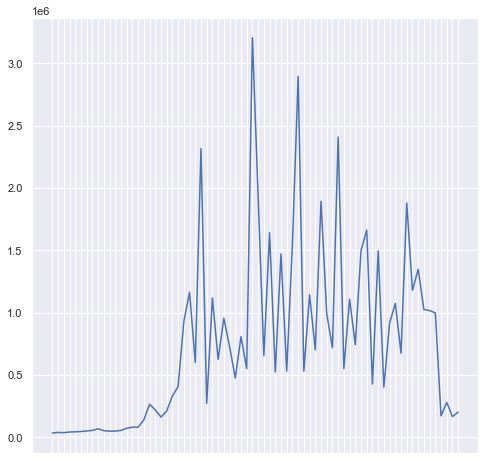

Song name: Piano Sonata No.21 in C Major, Op.53 "Waldstein": I. Allegro con brio
Key: 0, Mode: 1
Max frequency: bin_201-213


In [87]:
sample_number = 200
spectrum = fourier_df.iloc[sample_number, :]
plt.plot(fourier_cols, spectrum)
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.show()

key = df['key'][sample_number]
name = df['song_name'][sample_number]
mode = df['mode'][sample_number]
max_f = fourier_cols[spectrum.argmax()]
print(f'Song name: {name}')
print(f'Key: {key}, Mode: {mode}')
print(f'Max frequency: {max_f}')

### Classification

In [88]:
# Transform all keys to the relative major key
def modify_keys(df):
    df['key_modified'] = [(df['key'][index]+3) % 12 if mode==0 else df['key'][index] for index, mode in df['mode'].iteritems()]

    
# combine mode and key to one combined key_mode value
def combine_keys_and_modes(df):
    df['key_mode_combined'] = list(zip(df['key'], df['mode']))
    df['key_mode_combined'] = df['key_mode_combined'].apply(lambda x: x[0] if x[1]==1 else x[0]+12)
    
    
combine_keys_and_modes(df)    
modify_keys(df)

In [109]:
# Define model

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

X = fourier_df
y = df['key_modified']
NUM_CLASSES = y.nunique()

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(random_state=0, multi_class='multinomial', penalty='l2', solver='saga', max_iter=100, tol=1e-4)

In [110]:
# cross validation

print('Starting CV...')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Starting CV...
Mean Accuracy: 0.708 (0.040)


In [98]:
# Confusion matrix
print('Starting CV...')
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)
predictions = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
print('done')

Starting CV...
done


Accuracy: 0.7117601844734819


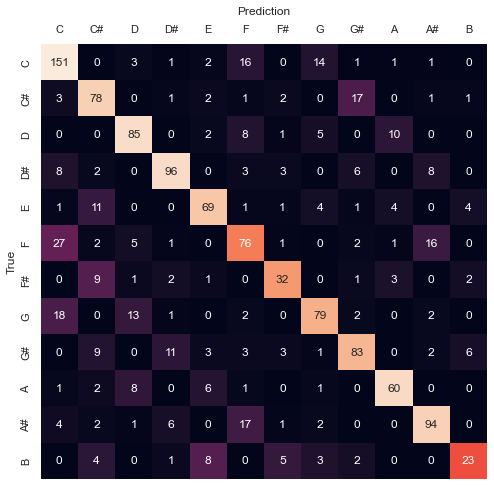

In [99]:
from sklearn.metrics import confusion_matrix, accuracy_score
print(f'Accuracy: {accuracy_score(y, predictions)}')
conf_matrix = confusion_matrix(y, predictions)
conf_matrix_normalized = confusion_matrix(y, predictions, normalize='true')

import seaborn as sns
plt.tick_params(axis='x', which='both', top=False, labeltop=True, bottom=False, labelbottom=False)
sns.set(rc={'figure.figsize':(10,10)})
s = sns.heatmap(conf_matrix_normalized, annot=conf_matrix, fmt='g', cbar=False)
ticklabels = (KEYS+MINOR_KEYS)[:NUM_CLASSES]
s.set(xticklabels=ticklabels, yticklabels=ticklabels)
s.set(ylabel='True')
plt.gca().xaxis.set_label_position('top') 
plt.gca().set_xlabel('Prediction', labelpad=10)
plt.gcf().savefig(f'../figures/heatmap_{dataset}_{NUM_CLASSES}.pdf')
plt.show()

### Feature Importance / Key Characterization

D:\Uni Master\Data Literacy\Project\spotipy-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(12, 12)


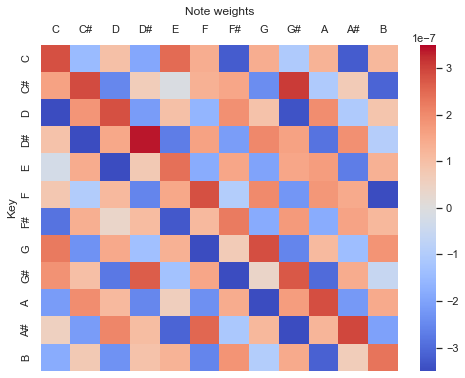

In [115]:
fitted = model.fit(X,y)

#sigs = fitted.coef_
sigs = fitted.coef_.reshape(NUM_CLASSES,6,12).mean(axis=1)
sigs = np.roll(sigs, axis=1, shift=-3)

plt.tick_params(axis='x', which='both', top=False, labeltop=True, bottom=False, labelbottom=False)
sns.set(rc={'figure.figsize':(8,6)})
s = sns.heatmap(sigs, annot=False, fmt='g', cbar=True, cmap='coolwarm', vmin=-3.5e-7, vmax=3.5e-7)
ticklabels = (KEYS+MINOR_KEYS)[:NUM_CLASSES]
print(sigs.shape)
s.set(xticklabels=KEYS, yticklabels=ticklabels)
s.set(ylabel='Key')
plt.gca().xaxis.set_label_position('top') 
plt.gca().set_xlabel('Note weights', labelpad=10)
plt.gcf().savefig(f'../figures/key_signatures_{dataset}_{NUM_CLASSES}.pdf')
plt.show()